<a href="https://colab.research.google.com/github/rahiakela/tensorflow-computer-vision-cookbook/blob/main/8-image-segmentation/3_implementing_image_segmentation_using_u_net_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implementing image segmentation using U-Net with transfer learning

Image segmentation is one of the biggest areas of study in computer vision. It consists of simplifying the visual contents of an image by grouping together pixels that share one or more defining characteristics, such as location, color, or texture. 

As is the case with many other subareas of computer vision, image segmentation has been greatly boosted by deep neural networks, mainly in industries such as medicine and autonomous driving.

While it's great to classify the contents of an image, more often than not, it's not enough.

What if we want to know exactly where an object is? 

What if we're interested in its shape? 

What if we need its contour? 

These fine-grained needs cannot be met with traditional classification techniques.

We can frame an image segmentation problem in a very similar way to a regular classification project. 

How?

Instead of labeling the image as a whole, we'll label each pixel! This is known as image segmentation.

## Implementing a U-Net with transfer learning

Training a U-Net from scratch is a very good first step toward creating a performant image segmentation system. However, one of the biggest superpowers in deep learning that's applied to computer vision is being able to build solutions on top of the knowledge of other networks, which usually leads to faster and better results.

Image segmentation is no exception to this rule, and in this recipe, we'll implement a better segmentation network using transfer learning.

## Setup

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [1]:
import pathlib

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import load_img

# Define an alias for tf.data.experimental.AUTOTUNE:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Loading and preparing dataset

Regarding the data, we will segment images from the Oxford-IIIT Pet dataset. The
good news is that we'll access it using tensorflow-datasets, so we don't really need to do anything in that respect here. 

Each pixel in this dataset is classified as follows:
- 1: The pixel belongs to a pet (cat or dog).
- 2: The pixel belongs to the contour of a pet.
- 3: The pixel belongs to the surroundings.

We will normalize the images in the dataset to the range [0, 1].
Just for consistency's sake, we'll subtract one from each pixel in the mask so that they go from 0 all the way to 2:

In [2]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

Let's loads both the image and its mask, given a TensorFlow dataset element. We will seize the opportunity to resize the images to `256x256` here. Also, if the train flag is set to True, we can perform a bit of augmentation by randomly mirroring the image and its mask. Lastly, we must normalize the inputs.

In [3]:
@tf.function
def load_image(dataset, train=True):
  input_image = tf.image.resize(dataset["image"], (256, 256))
  input_mask = tf.image.resize(dataset["segmentation_mask"], (256, 256))

  if train and np.random.uniform() > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

## Create Model Architecture

Let's implement a class, which encapsulates all the logic required to build, train, and evaluate our FCN image segmentation model.

In [4]:
class UNet(object):
  
  def __init__(self, input_size=(256, 256, 3), output_channels=3):

    self.pretrained_model = MobileNetV2(input_shape=input_size, include_top=False, weights="imagenet")

    self.target_layers = [
        'block_1_expand_relu',
        'block_3_expand_relu',
        'block_6_expand_relu',
        'block_13_expand_relu',
        'block_16_project'                  
    ]

    self.input_size = input_size 
    self.output_channels = output_channels 

    self.model = self._create_model()

    loss = SparseCategoricalCrossentropy(from_logits=True)
    self.model.compile(optimizer=RMSprop(), loss=loss, metrics=["accuracy"])

  @staticmethod
  def _upsample(filters, size, dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    layers = Sequential()
    layers.add(Conv2DTranspose(filters=filters, kernel_size=size, strides=2, padding="same", kernel_initializer=initializer, use_bias=False))
    layers.add(BatchNormalization())

    if dropout:
      layers.add(Dropout(rate=0.5))

    layers.add(ReLU())

    return layers

  def _create_model(self):
    layers = [self.pretrained_model.get_layer(l).output for l in self.target_layers]
    down_stack = Model(inputs=self.pretrained_model.input, outputs=layers)
    # only train the decoder or upsampling blocks of the architecture
    down_stack.trainable = False

    up_stack = []
    for filters in (512, 256, 128, 64):
      up_block = self._upsample(filters, 4)
      up_stack.append(up_block)

    inputs = Input(shape=self.input_size)
    x = inputs

    skip_layers = down_stack(x)
    x = skip_layers[-1]
    skip_layers = reversed(skip_layers[:-1])

    # add the skip connections to facilitate the flow of the gradient throughout the network
    for up, skip_connection in zip(up_stack, skip_layers):
      x = up(x)
      x = Concatenate()([x, skip_connection])
    
    init = tf.random_normal_initializer(0.0, 0.02)
    output = Conv2DTranspose(filters=self.output_channels, kernel_size=3, strides=2, padding="same", kernel_initializer=init)(x)

    return Model(inputs, outputs=output)

  @staticmethod
  def _plot_model_history(model_history, metric, ylim=True):
    plt.style.use('seaborn-darkgrid')
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({'Model': model_history}, metric=metric)

    plt.title(f'{metric.upper()}')
    if ylim is None:
        plt.ylim([0, 1])
    else:
        plt.ylim(ylim)

    plt.savefig(f'{metric}.png')
    plt.close()

  def train(self, train_dataset, epochs, steps_per_epoch, validation_dataset, validation_steps):
    hist = self.model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, validation_data=validation_dataset)

    self._plot_model_history(hist, 'loss', [0.0, 2.0])
    self._plot_model_history(hist, 'accuracy')

  @staticmethod
  def _process_mask(mask):
    """
    It is used to make the segmentation masks compatible with OpenCV. What this function does is create a three-channeled
    version of a grayscale mask and upscale the class values to the [0, 255] range
    """
    mask = (mask.numpy() * 127.5).astype("uint8")
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    return mask

  def _save_image_and_masks(self, image, ground_truth_mask, prediction_mask, image_id):
    """
    This method creates a mosaic of the original image, the ground truth mask, and the predicted segmentation mask, 
    and then saves it to disk for later revision
    """
    image = (image.numpy() * 255.0).astype('uint8')
    gt_mask = self._process_mask(ground_truth_mask)
    pred_mask = self._process_mask(prediction_mask)

    mosaic = np.hstack([image, gt_mask, pred_mask])
    mosaic = cv2.cvtColor(mosaic, cv2.COLOR_RGB2BGR)

    cv2.imwrite(f'mosaic_{image_id}.jpg', mosaic)

  @staticmethod
  def _create_mask(prediction_mask):
    """
    In order to pass the output volume produced by the network to a valid segmentation mask, we must take the index
    with the highest value at each pixel location. This corresponds to the most likely category for that pixel.
    """
    prediction_mask = tf.argmax(prediction_mask, axis=-1)
    prediction_mask = prediction_mask[..., tf.newaxis]

    return prediction_mask[0]

  def _save_predictions(self, dataset, sample_size=1):
    """
    This method uses the FCN to predict the mask of a sample of images in the input dataset. It then saves the result to disk.
    """
    for id, (image, mask) in enumerate(dataset.take(sample_size), start=1):
      pred_mask = self.model.predict(image)
      pred_mask = self._create_mask(pred_mask)

      image = image[0]
      ground_truth_mask = mask[0]

      self._save_image_and_masks(image, ground_truth_mask, pred_mask, image_id=id)

  def evaluate(self, test_dataset, sample_size=5):
    result = self.model.evaluate(test_dataset)
    print(f"Accuracy: {result[1] * 100:.2f}%")

    self._save_predictions(test_dataset, sample_size)

## Putting all stuffs together

Now let's download (or load, if cached) Oxford IIIT Pet Dataset, along with its
metadata, using TensorFlow Datasets:

In [ ]:
dataset, info = tfds.load("oxford_iiit_pet", with_info=True)

Now we use the metadata to define the corresponding number of steps the network will take over the training and validation datasets.

In [7]:
TRAIN_SIZE = info.splits['train'].num_examples
VALIDATION_SIZE = info.splits['test'].num_examples
BATCH_SIZE = 64
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE

VALIDATION_SUBSPLITS = 5
VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE
VALIDATION_STEPS //= VALIDATION_SUBSPLITS

BUFFER_SIZE = 1000

Let's define the training and testing datasets' pipelines:

In [8]:
train_dataset = (dataset["train"].map(load_image, num_parallel_calls=AUTOTUNE)
                                 .cache()
                                 .shuffle(BUFFER_SIZE)
                                 .batch(BATCH_SIZE)
                                 .repeat()
                                 .prefetch(buffer_size=AUTOTUNE))
test_dataset = (dataset["test"].map(lambda d: load_image(d, train=False), num_parallel_calls=AUTOTUNE)
                               .batch(BATCH_SIZE))

Now we will instantiate the FCN and train it for 120 epochs.

In [9]:
unet = UNet()
unet.train(train_dataset, epochs=30, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_dataset=test_dataset)

9412608/9406464 [==============================] - 0s 0us/step
Epoch 1/30
57/57 [==============================] - 124s 1s/step - loss: 0.4159 - accuracy: 0.8371 - val_loss: 2.5211 - val_accuracy: 0.6805
Epoch 2/30
57/57 [==============================] - 85s 1s/step - loss: 0.2787 - accuracy: 0.8879 - val_loss: 0.3391 - val_accuracy: 0.8908
Epoch 3/30
57/57 [==============================] - 81s 1s/step - loss: 0.2577 - accuracy: 0.8938 - val_loss: 0.2752 - val_accuracy: 0.8969
Epoch 4/30
57/57 [==============================] - 81s 1s/step - loss: 0.2456 - accuracy: 0.8979 - val_loss: 0.2705 - val_accuracy: 0.8952
Epoch 5/30
57/57 [==============================] - 81s 1s/step - loss: 0.2390 - accuracy: 0.9000 - val_loss: 0.2757 - val_accuracy: 0.8943
Epoch 6/30
57/57 [==============================] - 81s 1s/step - loss: 0.2285 - accuracy: 0.9035 - val_loss: 0.2471 - val_accuracy: 0.8996
Epoch 7/30
57/57 [==============================] - 81s 1s/step - loss: 0.2217 - accuracy: 0.905

Lastly, evaluate the network on the test dataset:

In [10]:
unet.evaluate(test_dataset)

58/58 [==============================] - 34s 577ms/step - loss: 0.3354 - accuracy: 0.8915
Accuracy: 89.15%


The accuracy on the test set should be close to 90%

The accuracy curves show that the network is not overfitting because both the
training and validation plots follow the same trajectory, with a very thin gap. This also confirms that the knowledge the model is acquiring is transferrable and usable on unseen data.

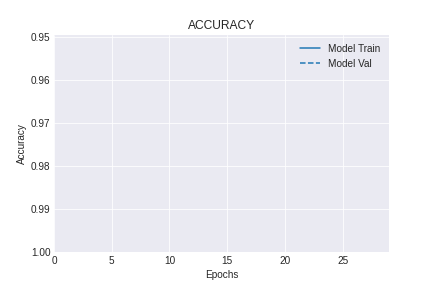

In [11]:
img = load_img("accuracy.png")
img

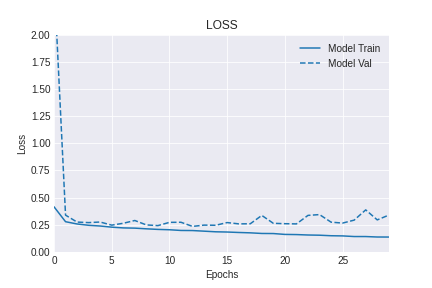

In [12]:
img = load_img("loss.png")
img

Take a look at the following image, which shows the original image, the ground
truth mask, and the produced mask.

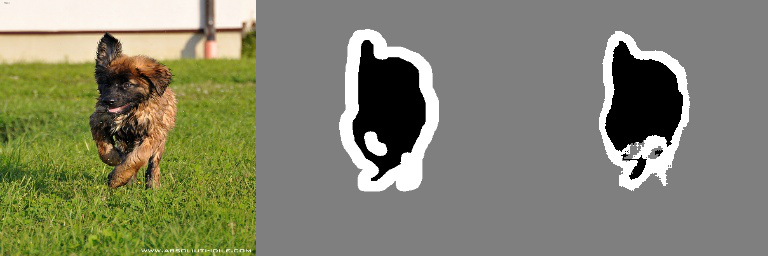

In [13]:
img = load_img("mosaic_1.jpg")
img

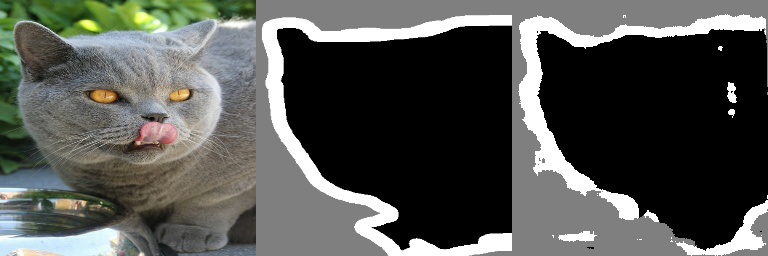

In [14]:
img = load_img("mosaic_2.jpg")
img

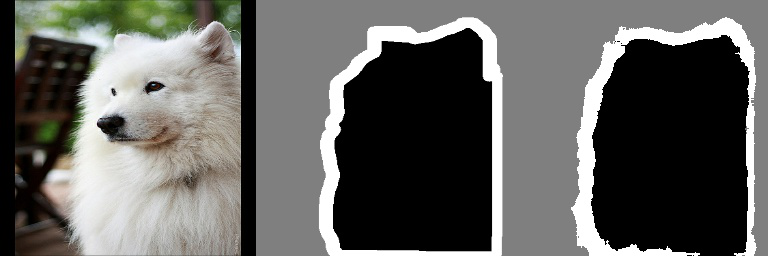

In [15]:
img = load_img("mosaic_3.jpg")
img

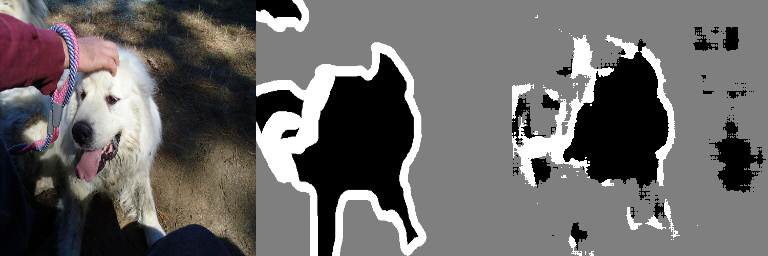

In [16]:
img = load_img("mosaic_4.jpg")
img

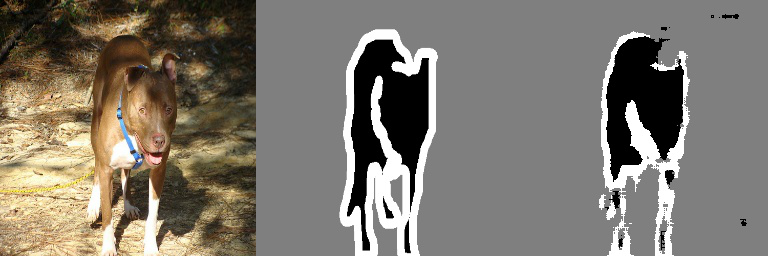

In [17]:
img = load_img("mosaic_5.jpg")
img

## Conclusions

Instead of training both the encoder and the decoder from scratch, we focused only on the upsampling layers (the decoder), leaving the encoding portion of the problem to a subset of target layers handpicked from a **MobileNetV2** trained on the massive ImageNet dataset.

The reason transfer learning worked so well in this context is that there are hundreds of classes in ImageNet focused on different breeds of cats and dogs, meaning the overlap with `Oxford IIIT Pet` is very substantial. However, if this wasn't the case, this doesn't mean we should drop transfer learning entirely! What we should do in that situation is fine-tune the encoder by making some (or all) of its layers trainable.

By leveraging the knowledge encoded in **MobileNetV2**, we were able to bump the
accuracy on the test set from 83% up to 90%, an impressive gain that translated into better, cleaner prediction masks, even on challenging examples.